# Procesos estocásticos en tiempo continuo

El ajuste a datos reales se logra con reescalamiento y combinación de procesos simulados de Weiner.
Empiezo por simulación de procesos individuales.


# Movimiento Browniano

### Convenciones:
Matriz de d trayectorias de una serie de n tiempos será matriz d x n. 


Trayectoria==individuo, cada tiempo una variable

Simulación de browniano:
$$B_{t+1}=B_t+\sqrt{t} Z_t, \quad Z_t~N(0,1)$$ 

0.0001 0.0001


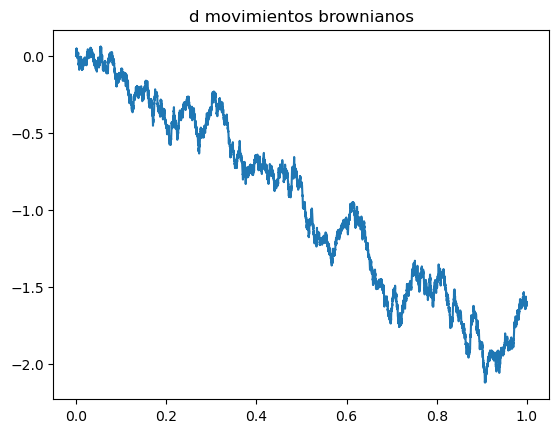

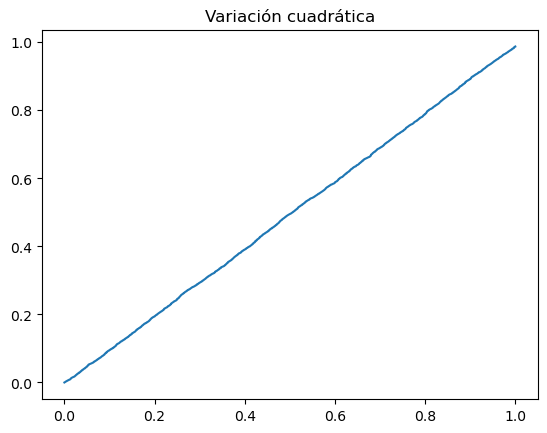

In [15]:
from typing import Optional
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def get_dB(n: int, Ts: float=1 , random_state: Optional[int] = None) -> np.ndarray:
    """
    Recibe:
    n: número deseado de incrementos.
    Ts: varianza=tiempo de muestreo (t-s). Por defecto =1
    Optional random_state to reproduce results.
    Retorna:
    dW: Vector con n incrementos de un MBEU
    """
    np.random.seed(random_state)
    sample=np.random.normal(0.0, Ts**(1/2), size=n-1)#Ts es la varianza, n-1 porque agrego luego condición inicial
    dB=np.insert(sample,0,0) #Agrego los estados iniciales como primer vector columna
    return dB

def get_B(n: int, Ts: float=1,random_state: Optional[int] = None) -> np.ndarray:
    """
    Recibe:
    n: tamaño de muestras deseadas.
    d: número de trayectorias muestreadas a intervalos Ts unidades de tiempo.
    Retorna:
    Matriz dxn con cada fila de la matriz como el vector de sumas acumuladas de los incrementos.
    """
    dB = get_dB(n,Ts=Ts,random_state=random_state)  #Cambiar por dB y B
    
    return np.cumsum(dB) #Cum sum retorna un vector y cada entrada se convierte en la suma acumulada

def quadratic_variation(B):
    """Devuelve la matriz (o el vector en caso de dimensión 1) con las variaciones cuadráticas de cada fila (mov browniano) de W"""
    if B.ndim==1:
        qv=np.cumsum(np.power(np.diff(B,prepend=0),2))
    else: 
        qv= np.cumsum(np.power(np.diff(B,axis=1,prepend=0),2),axis=1)
    return qv
T=1#Horizonte de tiempo
n=10000
d=5
time=np.linspace(0,T,n+1)#Con n+1 puntos obtengo 0=t_0<...<t_n=T, n subintervalos
Ts=T/n
print(Ts,time[1]-time[0])
B=get_B(n+1,Ts) 
plt.plot(time,B.T)#Para plot, Python asume que cada trayectoria es una columna
plt.title("d movimientos brownianos")
plt.show()
plt.plot(time,quadratic_variation(B).T)
plt.title("Variación cuadrática")
plt.show()

(array([-10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90.]),
 [Text(0, -10.0, '−10'),
  Text(0, 0.0, '0'),
  Text(0, 10.0, '10'),
  Text(0, 20.0, '20'),
  Text(0, 30.0, '30'),
  Text(0, 40.0, '40'),
  Text(0, 50.0, '50'),
  Text(0, 60.0, '60'),
  Text(0, 70.0, '70'),
  Text(0, 80.0, '80'),
  Text(0, 90.0, '90')])

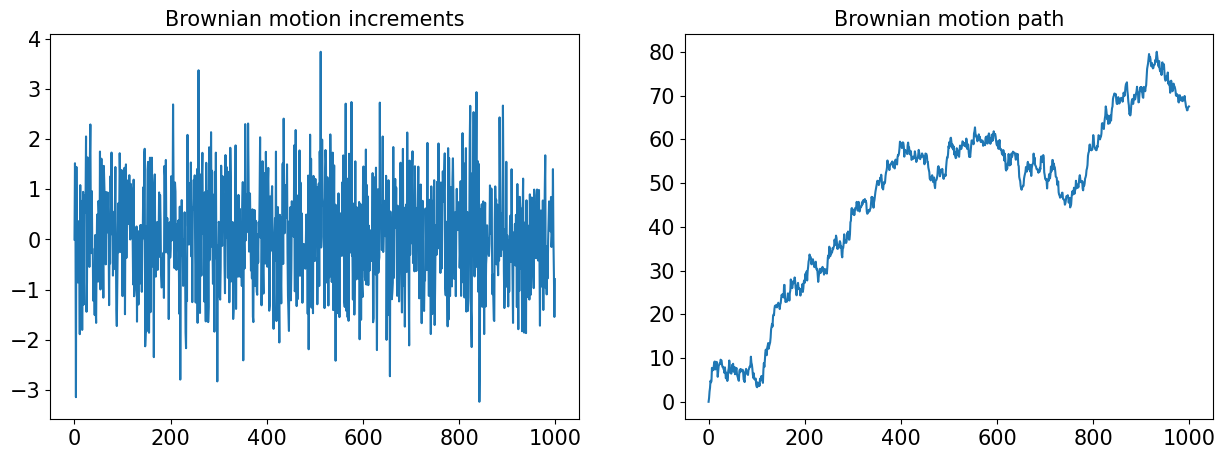

In [3]:
#simulación individual
dB = get_dB(1_000)
B  = get_B(1_000)

fig = plt.figure(figsize=(15, 5))

title = "Brownian motion increments"
plt.subplot(1, 2, 1)
plt.plot(dB.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

title = "Brownian motion path"
plt.subplot(1, 2, 2)
plt.plot(B.T)
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Correlacionados y matriz de d trayectorias
$W_3$ correlacionado con $W_1$. Con la relación $$dW_3(t)=\rho dW_1(t)+\sqrt{1-\rho^2}dW_2(t)$$
Se tiene que $corr(W_1,W_3)=\rho$.

Usualmente necesitaré múltiplos procesos. El segundo proceso correlacionado por $\rho$ con el primero, el segundo correlacionado por $\rho$ con una elección aleatoria de los procesos ya generados. Simularé una matriz con cada columna como un proceso browniano. 

La matriz será (dxn). Con $\rho=0$ o None, tengo d trayectorias independientes.

In [11]:


#############################################################################33
#Métodos viejos para que funcione la última parte del código que obtiene matriz con correlaciones. 
#Cambiar para que funcione con los nuevos


# def get_dW(T: int, random_state: Optional[int] = None) -> np.ndarray:
#     """
#     Sample T times from a normal distribution,
#     to simulate discrete increments (dW) of a Brownian Motion.
#     Optional random_state to reproduce results.
#     """
#     np.random.seed(random_state)
#     sample=np.random.normal(0.0, 1.0, T-1)
#     dW=np.insert(sample,0,0)
#     return dW

# def get_W(T: int, random_state: Optional[int] = None) -> np.ndarray:
#     """
#     Simula un movimiento Browuniano sampleado en unidades de tiempo.
#     Returns the cumulative sum
#     """
#     dW = get_dW(T, random_state)
#     return np.cumsum(dW) #Cum sum retorna un vector y cada entrada se convierte en la suma acumulada

######################################################################
#####################################################################3




def _get_correlated_dB(dB: np.ndarray, rho: float, Ts=1, d:int=1, random_state: Optional[int] = None) -> np.ndarray:
    """
    Recibe:
    Incrementos de browniano.
    rho: coeficiente de correlación.
    Ts: paso de muestreo.
    Retorna:
    d vectores de incrementos de procesos brownianos correlacionado.
    Sample correlated discrete Brownian increments to given increments dW.
    """
    dB2 = get_dB(len(dB), Ts=Ts, d=d, random_state=random_state)  # genera las d listas de incrementos.
    if np.array_equal(dB2, dB):
        # dB no puede ser igual a dB2.
        raise ValueError("Brownian Increment error, try choosing different random state.")
    return rho * dB + np.sqrt(1 - rho ** 2) * dB2


#Métodos auxiliares para matriz:

def _get_random_state_i(random_state: Optional[int], i: int) -> Optional[int]:
    """Add i to random_state if is int, else return None."""
    return random_state if random_state is None else random_state + i


def _get_previous_dB(
    dWs: list[np.ndarray], i: int, rng: np.random.Generator
) -> np.ndarray:
    """
    Elige un proceso dB parte de la matriz (ya generado).
    """
    random_proc_idx = rng.choice(i)
    return dWs[random_proc_idx]

def get_corr_dB_matrix(
    n: int,
    n_procs: int,
    rho: Optional[float] = None,
    random_state: Optional[int] = None,
) -> np.ndarray:
    """
    Matriz con d Brownianos dB, cada uno compuesto por n muestras de incrementos discretos.
    Cada fila será un proceso, por lo que resulta una matriz (dxn).
    rho es la correlación con la que se simularán los procesos a partir de alguno de los anteriormente simulados 
    (proceso elegido por la función _get)

    """
    rng = np.random.default_rng(random_state) #Generador
    dWs: list[np.ndarray] = []
    for i in range(n_procs):
        random_state_i = _get_random_state_i(random_state, i)
        if i == 0 or rho is None:
            dW_i = get_dB(n, random_state=random_state_i)
        else:
            dW_corr_ref = _get_corr_ref_dW(dWs, i, rng)
            dW_i = _get_correlated_dW(dW_corr_ref, rho, random_state_i)
        dWs.append(dW_i)
    return np.asarray(dWs).T
    



(array([ 0.5,  2.5,  4.5,  6.5,  8.5, 10.5, 12.5, 14.5, 16.5, 18.5, 20.5,
        22.5, 24.5, 26.5, 28.5, 30.5, 32.5, 34.5, 36.5, 38.5, 40.5, 42.5,
        44.5, 46.5, 48.5, 50.5, 52.5]),
 [Text(0, 0.5, '0'),
  Text(0, 2.5, '2'),
  Text(0, 4.5, '4'),
  Text(0, 6.5, '6'),
  Text(0, 8.5, '8'),
  Text(0, 10.5, '10'),
  Text(0, 12.5, '12'),
  Text(0, 14.5, '14'),
  Text(0, 16.5, '16'),
  Text(0, 18.5, '18'),
  Text(0, 20.5, '20'),
  Text(0, 22.5, '22'),
  Text(0, 24.5, '24'),
  Text(0, 26.5, '26'),
  Text(0, 28.5, '28'),
  Text(0, 30.5, '30'),
  Text(0, 32.5, '32'),
  Text(0, 34.5, '34'),
  Text(0, 36.5, '36'),
  Text(0, 38.5, '38'),
  Text(0, 40.5, '40'),
  Text(0, 42.5, '42'),
  Text(0, 44.5, '44'),
  Text(0, 46.5, '46'),
  Text(0, 48.5, '48'),
  Text(0, 50.5, '50'),
  Text(0, 52.5, '52')])

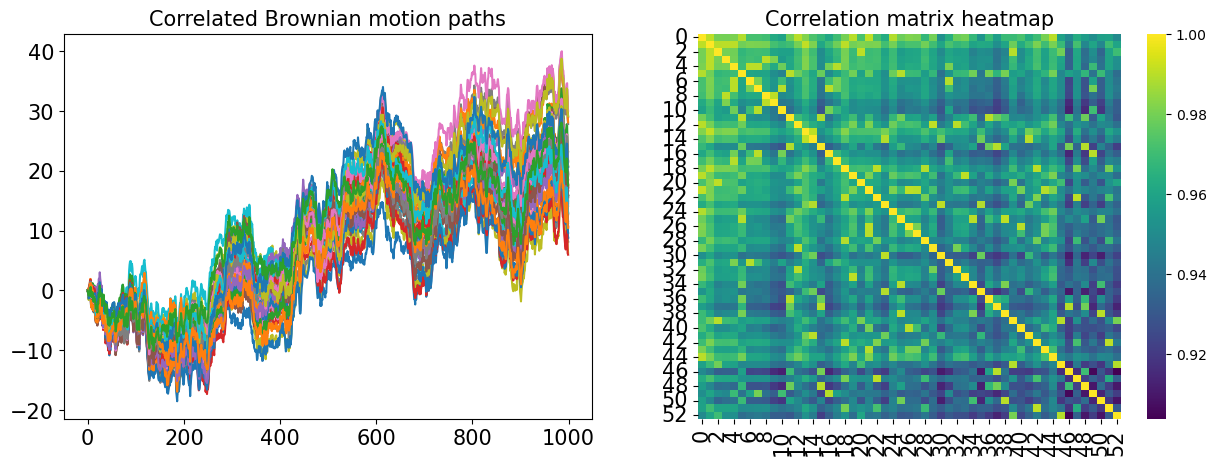

In [12]:
T = 1_000
n_procs = 53
rho = 0.99

corr_dWs = get_corr_dW_matrix(T, n_procs, rho)


#Plot
fig = plt.figure(figsize=(15, 5))

# paths
title = "Correlated Brownian motion paths"
plt.subplot(1, 2, 1)
plt.plot(np.cumsum(corr_dWs, axis=0))
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# correlation
title = "Correlation matrix heatmap"
plt.subplot(1, 2, 2)
sns.heatmap(np.corrcoef(corr_dWs, rowvar=False), cmap="viridis")
plt.gca().set_title(title, fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)